In [1]:
from scipy import optimize
from scipy.optimize import Bounds
from scipy.optimize import minimize
import pickle
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
hashmap = {0: (66, 0), 1: (132, 2), 2: (264, 6), 3: (132, 8), 4: (264, 12), 5: (132, 14), 6: (198, 17), 7: (66, 18), 8: (264, 22),
           9: (198, 25), 10: (66, 26), 11: (330, 31), 12: (66, 32), 13: (132, 34), 14: (66, 35), 15: (66, 36), 16: (132, 38), 17: (66, 39),
           18: (66, 40), 19: (132, 42), 20: (132, 44), 21: (264, 48), 22: (66, 49), 23: (132, 51), 24: (132, 53) 
           }

In [3]:
T_u, T_b, T_l = 150, 120, 90
initial_speed = 20

In [4]:
with open('true_data.pkl', 'rb') as f:
    profile_list = pickle.load(f)

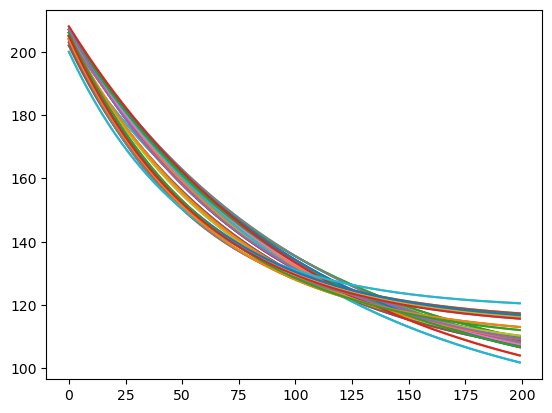

In [5]:
for profile in profile_list:
    plt.plot(profile)

In [6]:
def temp(t, b0, b1, T_env, T0):
    T = T_env - (b0/b1) + (T0 - T_env + (b0/b1))*np.exp(b1*(t))
    return T

def regression_for_one_layer(profile):
    reg = LinearRegression()
    T_env = 24

    X = [i - T_env for i in profile]
    X = X[:len(profile) - 1]
    Y = [profile[i + 1] - profile[i] for i in range(len(profile) - 1)]
    X = np.array(X).reshape(-1, 1)
    Y = np.array(Y).reshape(-1, 1)
    reg.fit(X, Y)
    b0 = reg.intercept_[0]
    b1 = reg.coef_[0][0]

    regression_profile = []
    for i in range(200):
        t = temp(i, b0, b1, T_env, profile[0])
        regression_profile.append(t)
    # plt.plot(regression_profile)
    # plt.plot(profile)
    # plt.show()
    return b0, b1, profile[0]

In [7]:
# b0_list = []
# b1_list = []
# T0_list = []
# true_data_params = []
# for profile in profile_list:
#     b0, b1, T0 = regression_for_one_layer(profile)
#     b0_list.append(b0)
#     b1_list.append(b1)
#     T0_list.append(T0)
#     true_data_params.append((b0, b1, T0))

In [8]:
# with open('../pkl_file/true_data_params.pkl', 'wb') as f:
#     pickle.dump(true_data_params, f)

In [7]:
with open('true_data_params.pkl', 'rb') as f:
    params = pickle.load(f)

In [8]:
b0_list = []
b1_list = []
T0_list = []
for param in params:
    b0, b1, T0 = param
    b0_list.append(b0)
    b1_list.append(b1)
    T0_list.append(T0)

In [11]:
# count = 0
# for i in range(54):
#     profile = []
#     for j in range(200):
#         profile.append(temp(j, b0_list[i], b1_list[i], 24,T0_list[i]))
#     plt.plot(profile)
#     count += 1
# print(count)

In [9]:
import gurobipy as gp
from gurobipy import GRB

### model without acceleration

In [ ]:
mdl = gp.Model('speed_control')
v = [mdl.addVar(vtype=GRB.CONTINUOUS, lb=5, ub=100, name=f'v{i}') for i in range(54)]
t = [mdl.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=500, name=f't{j}') for j in range(54)]
v_inverse = [mdl.addVar(vtype=GRB.CONTINUOUS, lb=0.01, ub=0.2, name=f'y{i}') for i in range(54)]
mdl.update()
for i in range(54):
    mdl.addConstr(v_inverse[i] * v[i] == 1, name=f'inv_constr_{i}')

for i in range(54):
    if i == 0:
        mdl.addConstr(v[i] >= 0.95 * initial_speed, name=f'constr_v{i}_lower')
        mdl.addConstr(v[i] <= 1.05 * initial_speed, name=f'constr_v{i}_upper')
    else:
        mdl.addConstr(v[i] >= 0.95 * v[i-1], name=f'constr_v{i}_lower')
        mdl.addConstr(v[i] <= 1.05 * v[i-1], name=f'constr_v{i}_upper')
for j in range(54):
    sum_term = gp.quicksum(66 * v_inverse[i] for i in range(j+1))
    mdl.addConstr(t[j] == (53-j)*(66/20) + sum_term)


exp_var = [mdl.addVar(name=f'exp_term{j}') for j in range(54)]
mul_var = [mdl.addVar(vtype=GRB.CONTINUOUS, lb=-10, ub=0, name=f'mul_var{j}') for j in range(54)] 
temperature_var = [mdl.addVar(name=f'temperature{j}') for j in range(54)] 
for j in range(54):
    mdl.addConstr(mul_var[j] == b1_list[j]*t[j], name=f'mul_constr{j}')
    mdl.addGenConstrExp(mul_var[j], exp_var[j], name=f'exp_constr{j}')
    mdl.addConstr(temperature_var[j] == 24 - (b0_list[j] / b1_list[j]) + (T0_list[j] - 24 + (b0_list[j] / b1_list[j])) * exp_var[j], 
                  name=f'temperature_constr{j}')

    
    mdl.addConstr(temperature_var[j] >= T_l, name=f'temp_lower_{j}')
    mdl.addConstr(temperature_var[j] <= T_u, name=f'temp_upper_{j}')
    
    
objective = gp.quicksum((temperature_var[j] - T_b)**2 for j in range(54))
mdl.setObjective(objective, GRB.MINIMIZE)
mdl.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 378 rows, 324 columns and 2077 nonzeros
Model fingerprint: 0xae9f5e1f
Model has 54 quadratic objective terms
Model has 54 quadratic constraints
Model has 54 general constraints
Variable types: 324 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [9e-03, 1e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e+02, 2e+02]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e-02, 5e+02]
  RHS range        [3e+00, 2e+02]
  QRHS range       [1e+00, 1e+00]
Presolve added 0 rows and 420 columns
Presolve removed 113 rows and 0 columns
Presolve time: 0.00s
Presolved: 481 rows, 744 columns, 2906 nonzeros
Presolved model has 51 SOS constraint(s)
Presolved model has 

In [56]:
for i in range(54):
    print(66 / v[i].X)

3.142857142857143
2.9931972789115644
2.850664075153871
2.7149181668132107
2.5856363493459145
2.4625108089008707
2.3452483894294005
2.2335698946946674
2.1272094235187304
2.025913736684505
1.9294416539852428
1.8375634799859455
1.7500604571294718
1.666724244885211
1.587356423700201
1.5117680225716201
1.4397790691158285
1.4255238308077514
1.5005514008502643
1.579527790368699
1.6626608319670517
1.7501692968074227
1.8422834703236026
1.9392457582353713
2.0413113244582854
2.148748762587669
2.238279961027017
2.1316952009798302
2.243889685241926
2.3619891423599224
2.4863043603788655
2.6171624846093313
2.492535699627935
2.623721789082037
2.7618124095600387
2.907170957431619
3.060179955191178
3.221242058095976
3.28698169193467
3.4599807283522837
3.6420849772126433
3.468652359250137
3.6512130097369857
3.843382115512616
4.045665384750122
4.258595141842234
4.482731728254982
4.718664977110508
4.493966644867149
4.279968233206809
4.505229719165062
4.742347072805328
4.991944287163502
5.254678197014213


In [57]:
miqcp_time = [sum(66 / v[i].X for i in range(54))]

In [58]:
miqcp_time

[151.36651105585446]

In [13]:
speed = [v[i].X for i in range(54)]
action = [speed[i] / speed[i-1] for i in range(1,54)]

In [15]:
speed

[21.0,
 22.05,
 23.1525,
 24.310125,
 25.525631250000004,
 26.801912812500007,
 28.14200845312501,
 29.549108875781258,
 31.026564319570323,
 32.57789253554884,
 34.206787162326286,
 35.9171265204426,
 37.71298284646473,
 39.59863198878797,
 41.578563588227375,
 43.65749176763874,
 45.84036635602068,
 46.29877001958088,
 43.98383151860184,
 41.78463994267175,
 39.695407945538165,
 37.71063754826126,
 35.8251056708482,
 34.03385038730579,
 32.3321578679405,
 30.715549974543478,
 29.486927975585512,
 30.961274374339826,
 29.413210655622837,
 27.942550122841695,
 26.54542261669961,
 25.218151485864638,
 26.47905906015787,
 25.155106107149976,
 23.897350801792477,
 22.702483261702856,
 21.567359098617715,
 20.48899114368683,
 20.079211320813094,
 19.07525075477244,
 18.121488217035246,
 19.027562627887008,
 18.076184496492658,
 17.172375271668027,
 16.313756508084627,
 15.498068682680398,
 14.723165248546378,
 13.98700698611906,
 14.686357335425013,
 15.420675202196266,
 14.649641442086454

In [14]:
action

[1.05,
 1.05,
 1.05,
 1.0500000000000003,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.0499999999999998,
 1.05,
 1.0099999999999998,
 0.9500000000000001,
 0.9500000000000001,
 0.95,
 0.9500000000000001,
 0.9500000000000002,
 0.95,
 0.9500000000000001,
 0.9500000000000001,
 0.960000000000774,
 1.0499999999991534,
 0.9500000000000001,
 0.95,
 0.9500000000000001,
 0.9500000000000003,
 1.05,
 0.95,
 0.95,
 0.9500000000000001,
 0.9500000000000001,
 0.9500000000000002,
 0.98,
 0.9500000000000001,
 0.9500000000000748,
 1.05,
 0.9500000000000001,
 0.9500000000000001,
 0.9500000000000001,
 0.9500000000000002,
 0.9500000000000001,
 0.9500000000000001,
 1.05,
 1.05,
 0.9500000000000001,
 0.9500000000000001,
 0.9500000000000001,
 0.95]

In [16]:
speed_history_mip = []
for j in range(54):
    # print(f'v[{j}] = {v[j].X}')
    speed_history_mip.append(v[j].X)

In [17]:
abs_temp_diff_mip = []
temp_diff_mip = []
for j in range(54):
    # print(f'temperature_var[{j}] = {temperature_var[j].X}')
    abs_temp_diff_mip.append(np.abs(temperature_var[j].X - T_b))
    temp_diff_mip.append(temperature_var[j].X - T_b)

In [18]:
with open('../pkl_file/abs_temp_diff_ppo.pkl', 'rb') as f:
    abs_temp_diff_ppo = pickle.load(f)
with open('../pkl_file/temp_diff_ppo.pkl', 'rb') as f:
    temp_diff_ppo = pickle.load(f)
with open('../pkl_file/speed_history_ppo.pkl', 'rb') as f:
    speed_history_ppo = pickle.load(f)
with open('../pkl_file/time_spent_ppo.pkl', 'rb') as f:
    time_spent_ppo = pickle.load(f)
with open('../pkl_file/abs_temp_diff_fixed.pkl', 'rb') as f:
    abs_temp_diff_fixed = pickle.load(f)
with open('../pkl_file/temp_diff_fixed.pkl', 'rb') as f:
    temp_diff_fixed = pickle.load(f)
with open('../pkl_file/speed_history_fixed.pkl', 'rb') as f:
    speed_history_fixed = pickle.load(f)
with open('../pkl_file/time_spent_fixed.pkl', 'rb') as f:
    time_spent_fixed = pickle.load(f)

In [66]:
sum(66 / speed_history_ppo[i] for i in range(54))

135.22110329234428

In [65]:
sum(time_spent_ppo)

134.27748506400874

In [64]:
ppo_time = [sum(time_spent_ppo[i] for i in range(54))]
ppo_time

[134.27748506400874]

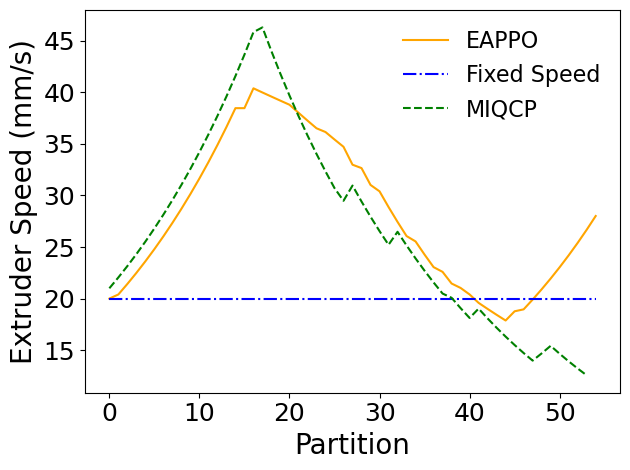

<Figure size 640x480 with 0 Axes>

In [44]:
plt.plot(speed_history_ppo, label='EAPPO', linestyle='solid', color='orange')
plt.plot(speed_history_fixed, label='Fixed Speed', linestyle='dashdot', color='blue')
plt.plot(speed_history_mip, label='MIQCP', linestyle='dashed', color='green')
plt.xlabel("Partition", fontsize=20)
plt.ylabel("Extruder Speed (mm/s)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig('../paper_plot/simplified_policy.png')
plt.show()
plt.clf()

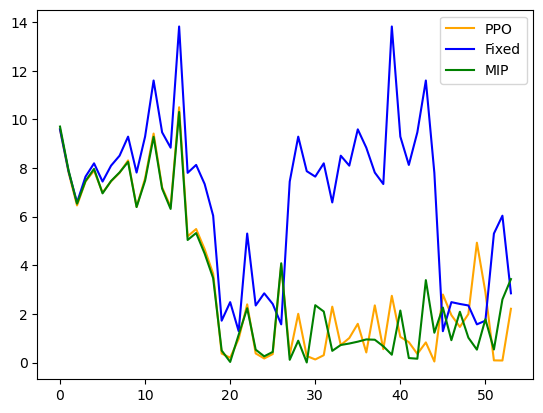

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(abs_temp_diff_ppo, label='EAPPO', color='orange')
plt.plot(abs_temp_diff_fixed, label='Fixed Speed', color='blue')
plt.plot(abs_temp_diff_mip, label='MIQCP', color='green')
plt.legend()
# plt.savefig('./ppomip_abs_temp_diff.png')
plt.show()
plt.clf()

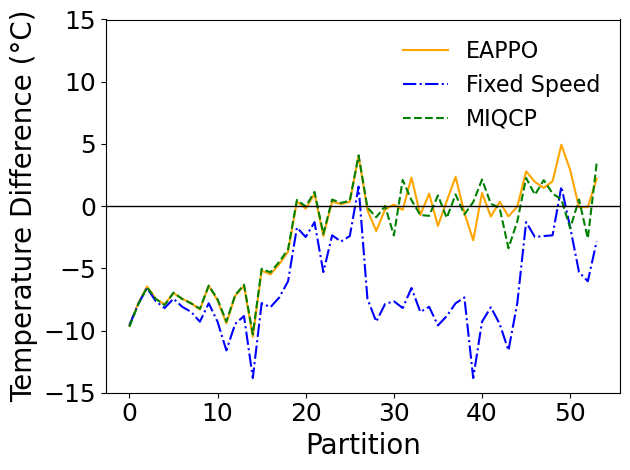

In [71]:
plt.plot(temp_diff_ppo, label='EAPPO', linestyle='solid', color='orange')
plt.plot(temp_diff_fixed, label='Fixed Speed', linestyle='dashdot', color='blue')
plt.plot(temp_diff_mip, label='MIQCP', linestyle='dashed', color='green')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.ylim(-15, 15)
plt.xlabel("Partition", fontsize=20)
plt.ylabel("Temperature Difference (°C)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.savefig('../paper_plot/simplified_performance.png')
plt.show()

In [48]:
diff_obj = sum([abs_temp_diff_mip[i]**2 for i in range(25)])
ppo_obj = sum([abs_temp_diff_ppo[i]**2 for i in range(25)])
fixed_obj = sum([abs_temp_diff_fixed[i]**2 for i in range(25)])

In [76]:
ppo_obj+=134.277

In [77]:
fixed_obj+=178.2

In [78]:
diff_obj+=151.366

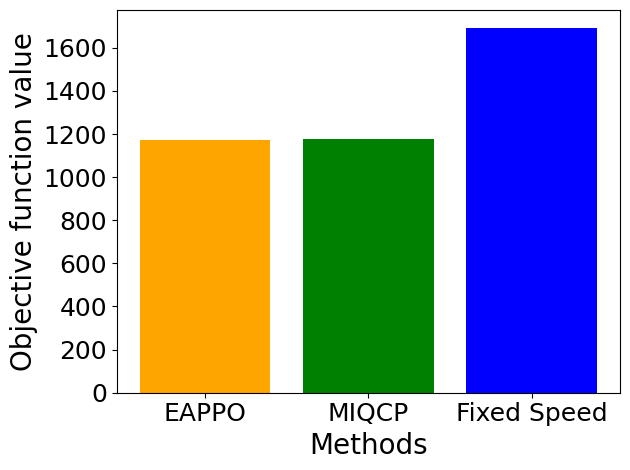

In [79]:
times = [ppo_obj, diff_obj, fixed_obj]
labels = ['EAPPO', 'MIQCP', 'Fixed Speed']
colors = ['orange', 'green', 'blue'] 
plt.bar(labels, times, color=colors)
plt.xlabel("Methods", fontsize=20)
plt.ylabel("Objective function value", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('../paper_plot/simplified_obj.png')
plt.show()

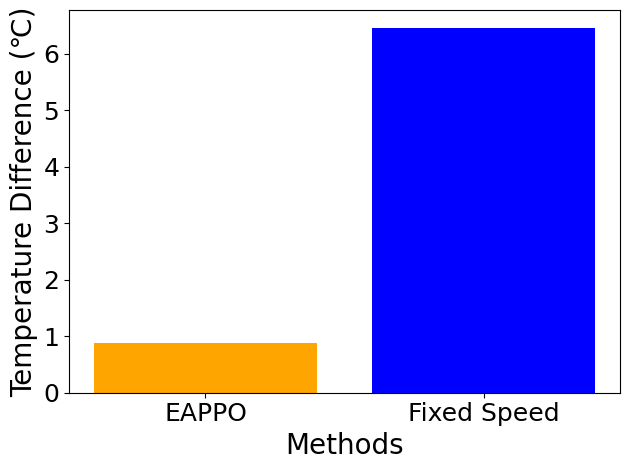

In [8]:
times = [0.88719, 6.448]
labels = ['EAPPO', 'Fixed Speed']
colors = ['orange', 'blue'] 
plt.bar(labels, times, color=colors)
plt.xlabel("Methods", fontsize=20)
plt.ylabel("Temperature Difference (℃)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('../paper_plot/case_study_compare_temp_diff.png')
plt.show()

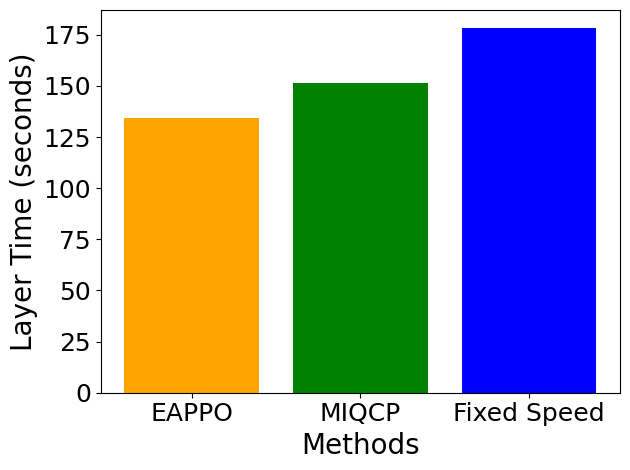

In [69]:
times = [134.277, 151.366, 178.2]
labels = ['EAPPO', 'MIQCP', 'Fixed Speed']
colors = ['orange', 'green', 'blue'] 
plt.bar(labels, times, color=colors)
plt.xlabel("Methods", fontsize=20)
plt.ylabel("Layer Time (seconds)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('../paper_plot/simplified_layer_time.png')
plt.show()

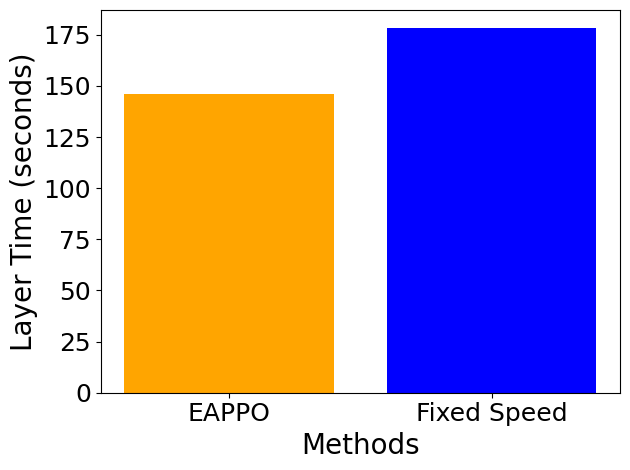

In [5]:
times = [146.05, 178.2]
labels = ['EAPPO', 'Fixed Speed']
colors = ['orange', 'blue'] 
plt.bar(labels, times, color=colors)
plt.xlabel("Methods", fontsize=20)
plt.ylabel("Layer Time (seconds)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('../paper_plot/case_study_compare_layer_time.png')
plt.show()

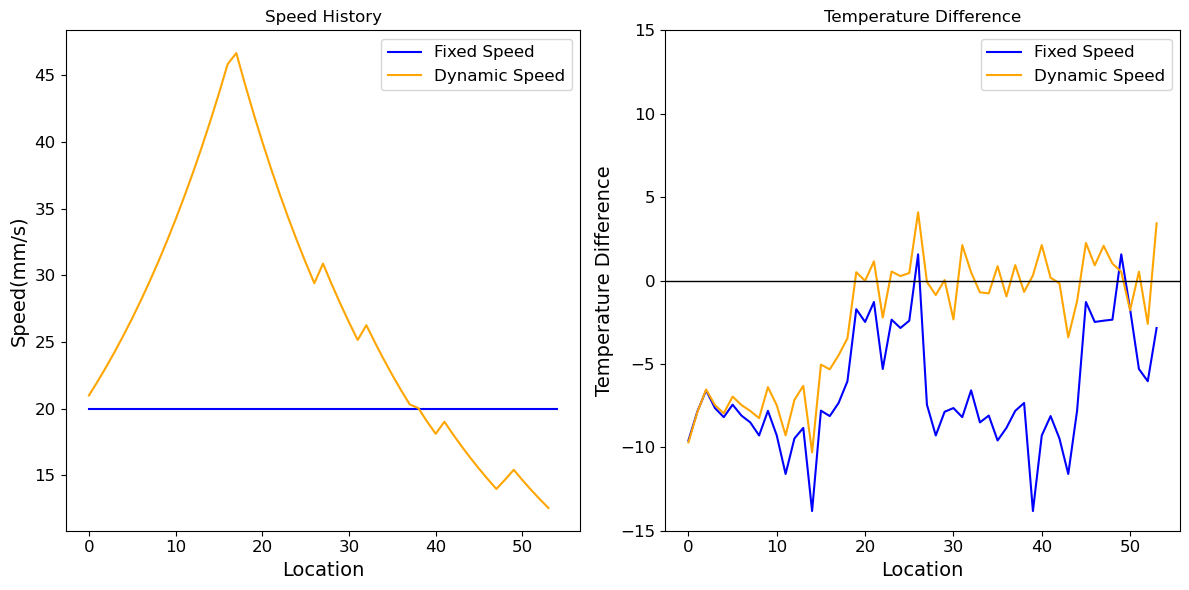

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt

# 创建并排的两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 创建 1 行 2 列的子图，尺寸一致

# 绘制第一个图
ax1.plot(speed_history_fixed, label='Fixed Speed', color='blue')
ax1.plot(speed_history_mip, label='Dynamic Speed', color='orange')
ax1.set_xlabel("Location", fontsize=14)
ax1.set_ylabel("Speed(mm/s)", fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)  # 设置刻度字体大小
ax1.legend(fontsize=12)
ax1.set_title('Speed History')  # 可选标题

# 绘制第二个图
ax2.plot(temp_diff_fixed, label='Fixed Speed', color='blue')
ax2.plot(temp_diff_mip, label='Dynamic Speed', color='orange')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_ylim(-15, 15)
ax2.set_xlabel("Location", fontsize=14)
ax2.set_ylabel("Temperature Difference", fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(fontsize=12)
ax2.set_title('Temperature Difference')  # 可选标题

# 自动调整子图布局，防止标签重叠
plt.tight_layout()

# 保存图像
plt.savefig('./mip_combined.png')

# 显示图像
plt.show()

# 清空图像
plt.clf()


In [23]:
# ppo_mip_diff = []
# for i in range(len(abs_temp_diff_fixed)):
#     ppo_mip_diff.append(abs_temp_diff_mip[i] - abs_temp_diff_ppo[i])
# plt.scatter(range(54), ppo_mip_diff)
# plt.show()

In [24]:
# sum(ppo_mip_diff)

### Model with acceleration

In [25]:
a = 50
M = 1000

In [26]:
mdl = gp.Model('speed_control_without_acceleration')
# speed, we calculate acceleration based on speed
v = [mdl.addVar(vtype=GRB.CONTINUOUS, lb=5, ub=100, name=f'v{i}') for i in range(54)]
# square of speed
v_square = [mdl.addVar(vtype=GRB.CONTINUOUS, lb=25, ub=10000, name=f'v_square{i}') for i in range(54)]
# 1 / speed
v_inverse = [mdl.addVar(vtype=GRB.CONTINUOUS, lb=0.01, ub=0.2, name=f'y{i}') for i in range(54)]
# acceleration distance for each partition
d = [mdl.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=66, name=f'distance{i}') for i in range(54)]
v_inside_partition = [[mdl.addVar(vtype=GRB.CONTINUOUS, lb=5, ub=100, name=f'v_inside_partition{partition}{i}') for i in range(660)] for partition in range(54)]
v_inside_partition_square = [[mdl.addVar(vtype=GRB.CONTINUOUS, lb=5, ub=100, name=f'v_inside_partition_square{partition}{i}') for i in range(660)] for partition in range(54)]
t = [[mdl.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=500, name=f't_{partition}_{i}') 
      for i in range(660)] for partition in range(54)]
inside_acceleration = [[mdl.addVar(vtype=GRB.BINARY, name=f'inside_acceleration_{partition}_{i}') 
                        for i in range(660)] for partition in range(54)]
v_inside_average = [[mdl.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=100, name=f'v_inside_avg{i}') for i in range(660)] for partition in range(54)]
# sign to calculate time
delta_v_positive = [mdl.addVar(vtype=GRB.BINARY, name=f'delta_v_positive{i}') for i in range(54)]
mdl.update()
for i in range(54):
    mdl.addConstr(v_inverse[i] * v[i] == 1, name=f'inv_constr_{i}')
    mdl.addConstr(v_square[i] == v[i]*v[i])

In [27]:
for i in range(54):
    if i == 0:
        mdl.addConstr(v[i] >= 0.95 * initial_speed, name=f'constr_v{i}_lower')
        mdl.addConstr(v[i] <= 1.05 * initial_speed, name=f'constr_v{i}_upper')
    else:
        mdl.addConstr(v[i] >= 0.95 * v[i-1], name=f'constr_v{i}_lower')
        mdl.addConstr(v[i] <= 1.05 * v[i-1], name=f'constr_v{i}_upper')

In [28]:
# get acceleration distance for each partition
for i in range(54):
    if i == 0:
        mdl.addConstr(v[i] - initial_speed <= M * delta_v_positive[i])
        mdl.addConstr(v[i] - initial_speed >= (1 - delta_v_positive[i]) * (-M))

        mdl.addConstr(d[i] == delta_v_positive[i] * (v_square[i] - initial_speed**2) / (2 * a) + (1 - delta_v_positive[i]) * (initial_speed**2 - v_square[i]) / (2 * a))
    else:
        mdl.addConstr(v[i] - v[i-1] <= M * delta_v_positive[i])  
        mdl.addConstr(v[i] - v[i-1] >= (1 - delta_v_positive[i]) * (-M))
        
        mdl.addConstr(d[i] == delta_v_positive[i] * (v_square[i] - v_square[i-1]) / (2 * a) + (1 - delta_v_positive[i]) * (v_square[i-1] - v_square[i]) / (2 * a))

In [29]:
for partition in range(54):
    for i in range(660):
        mdl.addConstr(0.1 * (i+1) - d[partition] <= M * (1 - inside_acceleration[partition][i]))
        mdl.addConstr(d[partition] - 0.1  * (i+1) <= M * inside_acceleration[partition][i])

In [30]:
for partition in range(54):
    for i in range(660):
        v_inside_partition_square[partition][i] = v_inside_partition[partition][i] * v_inside_partition[partition][i]

In [31]:
mdl.addConstr(v_inside_partition[0][0] == initial_speed + 2*a*0.1*inside_acceleration[0][0])
for partition in range(1, 54):
    mdl.addConstr(v_inside_partition[partition][0] == v[partition-1] + 2*a*0.1*inside_acceleration[partition][0])

for partition in range(54):
    for i in range(1, 660):
        mdl.addConstr(v_inside_partition_square[partition][i] == v_inside_partition_square[partition][i-1] + 2*a*0.1*inside_acceleration[partition][i])

In [32]:
mdl.addConstr(v_inside_average[0][0] * (initial_speed + v_inside_partition[0][0]) == 2)
for partition in range(1, 54):
    mdl.addConstr(v_inside_average[partition][0] *(v[partition-1] + v_inside_partition[partition][0]) == 2)
for partition in range(54):
    for i in range(1, 660):
        mdl.addConstr(v_inside_average[partition][i] * (v_inside_partition[partition][i] + v_inside_partition[partition][i-1]) == 2)

In [33]:
for partition in range(54):
    for i in range(660):
        mdl.addConstr(t[partition][i] == 0.1 * v_inside_average[partition][i])

In [34]:
prefix_sum = [[mdl.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name=f'prefix_sum_{partition}_{i}') 
               for i in range(660)] for partition in range(54)]

In [35]:
for partition in range(54):
    for i in range(660):
        if partition == 0 and i == 0:
            mdl.addConstr(prefix_sum[partition][i] == t[partition][i])
        elif partition == 0:
            mdl.addConstr(prefix_sum[partition][i] == prefix_sum[partition][i-1] + t[partition][i])
        elif i == 0:
            mdl.addConstr(prefix_sum[partition][i] == prefix_sum[partition-1][660-1] + t[partition][i])
        else:
            mdl.addConstr(prefix_sum[partition][i] == prefix_sum[partition][i-1] + t[partition][i])

In [36]:
t_profile = [[mdl.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name=f't_profile_{partition}_{i}') 
      for i in range(660)] for partition in range(54)]

In [37]:
for partition in range(54):
    for i in range(660):
        sum_term = prefix_sum[partition][i]
        mdl.addConstr(t_profile[partition][i] == (53 - partition) * (66/20) + sum_term)

In [38]:
exp_var = [[mdl.addVar(name=f'exp_term{partition}_{i}') for i in range(660)] for partition in range(54)]
mul_var = [[mdl.addVar(vtype=GRB.CONTINUOUS, lb=-10, ub=0, name=f'mul_var{partition}_{i}') for i in range(660)] for partition in range(54)]
temperature_var = [[mdl.addVar(name=f'temperature{partition}{i}') for i in range(660)] for partition in range(54)]

In [39]:
for partition in range(54):
    for i in range(660):
        mdl.addConstr(mul_var[partition][i] == b1_list[partition] * t_profile[partition][i])
        mdl.addGenConstrExp(mul_var[partition][i], exp_var[partition][i])
        mdl.addConstr(temperature_var[partition][i] == 24 - (b0_list[partition] / b1_list[partition]) + (T0_list[partition] - 24 + (b0_list[partition] / b1_list[partition])) * exp_var[partition][i])
        mdl.addConstr(temperature_var[partition][i] >= T_l)
        mdl.addConstr(temperature_var[partition][i] <= T_u)

In [40]:
objective = gp.quicksum((temperature_var[partition][i] - T_b) * (temperature_var[partition][i] - T_b)
                        for partition in range(54)
                        for i in range(660))

In [41]:
mdl.setObjective(objective, GRB.MINIMIZE)
mdl.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 321030 rows, 356670 columns and 606576 nonzeros
Model fingerprint: 0xe9898116
Model has 35640 quadratic objective terms
Model has 71388 quadratic constraints
Model has 35640 general constraints
Variable types: 320976 continuous, 35694 integer (35694 binary)
Coefficient statistics:
  Matrix range     [9e-03, 1e+03]
  QMatrix range    [2e-02, 1e+00]
  QLMatrix range   [1e-02, 2e+01]
  Objective range  [2e+02, 2e+02]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e-02, 1e+04]
  RHS range        [1e-01, 1e+03]
  QRHS range       [1e+00, 4e+00]
Presolve removed 274314 rows and 227739 columns (presolve time = 5s) ...
Presolve added 0 rows and 158707 columns
Presolve removed 156528 rows and 0 columns
Presolve time: 5.68s
Presolved: 515653 rows, 584920 columns, 2284128 nonzeros
Pr